In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import xarray as xr
import os
import random
from scipy.stats import linregress, norm, ttest_1samp, t

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

In [2]:
models = [
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM2",
    "CNRM-CM6-1",
    "EC-Earth3",
    "GISS-E2-1-G",
    "GISS-E2-1-H",
    "INM-CM5-0",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MIROC-ES2L",
    "MPI-ESM1-2-LR",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
    "NorCPM1",
    "UKESM1-0-LL",
]

variables = ["tas", "rsut", "rsdt"]

### Load CMIP6 data

In [3]:
model_dict = {}

droot = "../data/processed"

for name in models:
    print(f"Model = {name}")
    model_dict[name] = {}
    for var in variables:
        ddir = os.path.join(droot, name, "historical")
        if var == "tas":
            dfile = var+"_"+name+"_historical_ens_tseries_globmean_198001-201412.nc"
        else:
            dfile = var+"_"+name+"_historical_ens_tseries_tropmean_198001-201412.nc"
        ncf = os.path.join(ddir, dfile)
        ds = xr.open_dataset(ncf)

        model_dict[name][var] = ds[var]
        
    model_dict[name]["rsnt"] = model_dict[name]["rsdt"] - model_dict[name]["rsut"]

Model = ACCESS-ESM1-5
Model = CanESM5
Model = CESM2
Model = CNRM-CM6-1
Model = EC-Earth3
Model = GISS-E2-1-G
Model = GISS-E2-1-H
Model = INM-CM5-0
Model = IPSL-CM6A-LR
Model = MIROC6
Model = MIROC-ES2L
Model = MPI-ESM1-2-LR
Model = MPI-ESM1-2-HR
Model = MRI-ESM2-0
Model = NorCPM1
Model = UKESM1-0-LL


In [4]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    dafit = da.where(np.logical_or(da.time < np.datetime64("1991-06"),
                                   da.time > np.datetime64("2001-05")),
                      drop=True)
    p = dafit.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### Compute anomalies

In [5]:
data_dict = {}

for name in model_dict.keys():
    if name == "CESM2-LENS":
        tvar = "TREFHT"
        rvar = "FSNT"
        sgn = -1
    else:
        tvar = "tas"
        rvar = "rsut"
        sgn = 1

    data_dict[name] = {}

    print(f"Model = {name}")

    temp = model_dict[name][tvar]
    netsw = model_dict[name][rvar]

    tanalysis = detrend_dim(temp.sel(time=slice("1986-01", "2005-12")), "time")
    tbase = tanalysis.sel(time=slice("1986-01", "1990-12"))

    sanalysis = detrend_dim(netsw.sel(time=slice("1986-01", "2005-12")), "time")
    sbase = sanalysis.sel(time=slice("1986-01", "1990-12"))

    tpert = tanalysis.groupby("time.month") - tbase.groupby("time.month").mean("time")
    spert = sanalysis.groupby("time.month") - sbase.groupby("time.month").mean("time")

    data_dict[name]["tpert"] = tpert.compute()
    data_dict[name]["spert"] = sgn*spert.compute()
    data_dict[name]["ens"] = tpert["ensmem"].size

Model = ACCESS-ESM1-5
Model = CanESM5
Model = CESM2
Model = CNRM-CM6-1
Model = EC-Earth3
Model = GISS-E2-1-G
Model = GISS-E2-1-H
Model = INM-CM5-0
Model = IPSL-CM6A-LR
Model = MIROC6
Model = MIROC-ES2L
Model = MPI-ESM1-2-LR
Model = MPI-ESM1-2-HR
Model = MRI-ESM2-0
Model = NorCPM1
Model = UKESM1-0-LL


### Integrate anomalies as in Bender et al., 2010

In [6]:
int_dict = {}

for name in model_dict.keys():
    int_dict[name] = {}
    int_dict[name]["temp"] = data_dict[name]["tpert"].sel(time=slice("1991-06", "1995-05")).sum("time")
    int_dict[name]["sw"] = data_dict[name]["spert"].sel(time=slice("1991-06", "1993-05")).sum("time")
    int_dict[name]["ens"] = data_dict[name]["ens"]

### Get ECS data from Zelinka et al., 2020

In [7]:
import json
f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test

ACCESS-ESM1-5 = 3.8839034758064814
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253567
MIROC6 = 2.601790969650521
MIROC-ES2L = 2.6605264351565174
MPI-ESM1-2-LR = 3.0254401947450527
MPI-ESM1-2-HR = 2.9797516932086876
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.0317257208870005
UKESM1-0-LL = 5.359162439690016


In [8]:
N = 10000
tslopes = np.zeros(N)
sslopes = np.zeros(N)
rslopes = np.zeros(N)

rslopes_trunc = np.zeros(N)

### Randomly choose same number of models and ensemble members as in Bender et al. compute ratio, and repeat N times

In [9]:
for n in range(N):
    mod = random.sample(models, 9)

    tdata = np.zeros(9)
    sdata = np.zeros(9)
    rdata = np.zeros(9)
    ecs = np.zeros(9)
    for m, name in enumerate(mod):
        ens = np.arange(int_dict[name]["ens"])
        if m < 7:
            mems = np.random.choice(ens[:7], 3, replace=False)
        else:
            mems = np.random.choice(ens[7:], 1, replace=False)

        tdata[m] = int_dict[name]['temp'].isel(ensmem=mems).mean("ensmem")
        sdata[m] = int_dict[name]['sw'].isel(ensmem=mems).mean("ensmem")
        rdata[m] = tdata[m]/sdata[m]
        ecs[m] = ecs_dict[name]

    tslope, intcpt, r, p, stderr = linregress(ecs, tdata)
    sslope, intcpt, r, p, stderr = linregress(ecs, sdata)
    rslope, rintcpt, r, p, stderr = linregress(ecs, rdata)

    tslopes[n] = tslope
    sslopes[n] = sslope
    rslopes[n] = rslope

### Slope from Bender et al. paper using CMIP3 data

In [10]:
bender_slope = -0.022398258141252

Area above 0 =  0.291


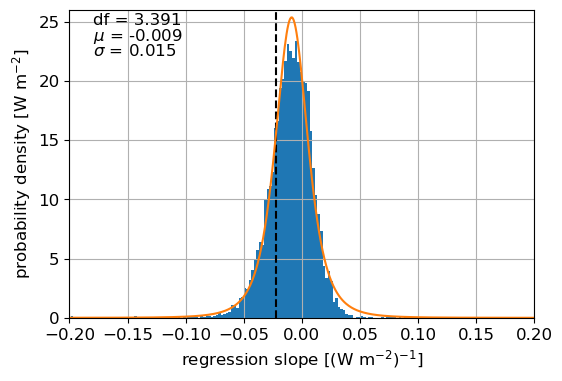

In [11]:
fig = plt.figure(1)
plt.hist(rslopes, bins="auto", density=True)
plt.plot([bender_slope, bender_slope], [0, 50], "k--")
x = np.linspace(min(rslopes), max(rslopes), 1000)
df, mu, std = t.fit(rslopes)

area = t.cdf(1, df, loc=mu, scale=std) - t.cdf(0, df, loc=mu, scale=std)
print(f"Area above 0 = {area: 5.3f}")
plt.plot(x, t.pdf(x, df, mu, std))
plt.ylabel("probability density [W m$^{-2}$]")
plt.xlabel("regression slope [(W m$^{-2}$)$^{-1}$]")
plt.grid()
plt.ylim(0, 26)
plt.xlim(-0.2, 0.2)

plt.annotate(f"df = {df:5.3f}", xy=(0.05, 0.95), xycoords="axes fraction")
plt.annotate(f"$\mu$ = {mu:5.3f}", xy=(0.05, 0.9), xycoords="axes fraction")
plt.annotate(f"$\sigma$ = {std:5.3f}", xy=(0.05, 0.85), xycoords="axes fraction")

fig.savefig("../figures/montecarlo_rslopes.pdf",
            bbox_inches="tight")

In [12]:
a, b = t.interval(alpha=0.95, df=df, loc=mu, scale=std)
print(f"95% Confidence interval: ({a:5.4f}, {b:5.4f})")

95% Confidence interval: (-0.0525, 0.0348)


/var/folders/fx/t8hgkk_n3z1fz9z_z3q6qlcsvq921y/T/ipykernel_35154/3924656796.py:1: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  a, b = t.interval(alpha=0.95, df=df, loc=mu, scale=std)
